<a href="https://colab.research.google.com/github/Guimartinslimaoliveira/Python_Projects/blob/main/MSFT_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este notebook tem a intenção de estudar a utilização de algoritimos de aprendizado de maquina e redes neurais, fazer o tratamento de dados retirados do site 'https://br.investing.com/' os dados historicos selecionados foram os da microsoft de 1993 até a data atual de 03/02/2025, meu objetivo é Tentar prever com Tensorflow e sklearn ,xgboost, FBProphet os valores futuros da Stock option com pelo menos 70% de acuracia, para ajudar a tomar melhores decisões na entrada e na saida de posições e avaliar quais os melhores modelos para este caso.

Começaremos checando a versão do python

In [ ]:
!python --version

Python 3.11.11


In [ ]:
!pip install --upgrade scikit-learn xgboost

Vamos importar as bibliotecas necessarias para começar

In [ ]:
#importando as bibliotecas essenciais para analise, limpeza e transformação
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import xgboost as xgb

#importando as bilbiotecas essenciais para treinamento e teste.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


Agora vamos importar os dados históricos.


In [ ]:
#importando do google drive nossos dados
dados = pd.read_csv('/content/drive/MyDrive/Datascience/MSFT.csv')
dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,03.02.2025,"413,56","411,69","415,41","408,68","16,89M","-0,36%"
1,31.01.2025,"415,06","418,98","420,69","414,91","34,22M","0,02%"
2,30.01.2025,"414,99","418,77","422,86","413,16","54,59M","-6,18%"
3,29.01.2025,"442,33","446,69","446,88","440,40","23,58M","-1,09%"
4,28.01.2025,"447,20","434,60","448,38","431,38","23,49M","2,91%"


 Os dados já foram importados e podemos ver que temos 5000 linhas de dados, vamos analisar a estrutura dos dados.

In [ ]:
#vizualizando a estrutura dos dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8080 entries, 0 to 8079
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Data      8080 non-null   object
 1   Último    8080 non-null   object
 2   Abertura  8080 non-null   object
 3   Máxima    8080 non-null   object
 4   Mínima    8080 non-null   object
 5   Vol.      8080 non-null   object
 6   Var%      8080 non-null   object
dtypes: object(7)
memory usage: 442.0+ KB


Devido a estrutura de objeto dos dados importados termos que transformar os dados importantes das colunas para os formatos que vamos usar nos modelos de aprendizado


vamos começar transformando a coluna data em datatime usando o pandas

In [ ]:
#usando pandas para converter a coluna "Data" para datetime
dados['Data'] = pd.to_datetime(dados['Data'], format = '%d.%m.%Y')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8080 entries, 0 to 8079
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      8080 non-null   datetime64[ns]
 1   Último    8080 non-null   object        
 2   Abertura  8080 non-null   object        
 3   Máxima    8080 non-null   object        
 4   Mínima    8080 non-null   object        
 5   Vol.      8080 non-null   object        
 6   Var%      8080 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 442.0+ KB


No proximo passo vamos continuar transformando os valores das colunas:

*   Último    
*   Abertura
*   Máxima    
*   Mínima
*   Vol.
*   Var%

Para isso vamos transformar as colunas selecionadas e converte automaticamente as strings para float64







In [ ]:
#Vamos fazendo a troca de "," para "."
#assim podemos converter para float em seguida

dados['Último'] = dados['Último'].str.replace(',','.')
dados['Último'] = dados['Último'].astype(float)

dados['Abertura'] = dados['Abertura'].str.replace(',','.')
dados['Abertura'] = dados['Abertura'].astype(float)

dados['Máxima'] = dados['Máxima'].str.replace(',','.')
dados['Máxima'] = dados['Máxima'].astype(float)

dados['Mínima'] = dados['Mínima'].str.replace(',','.')
dados['Mínima'] = dados['Mínima'].astype(float)



dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8080 entries, 0 to 8079
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      8080 non-null   datetime64[ns]
 1   Último    8080 non-null   float64       
 2   Abertura  8080 non-null   float64       
 3   Máxima    8080 non-null   float64       
 4   Mínima    8080 non-null   float64       
 5   Vol.      8080 non-null   object        
 6   Var%      8080 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 442.0+ KB


Poderiamos criar uma função que converte automaticamente cada uma das colunas no tipo pretendido mas para fins de estudo e treinamento farei a conversão uma a uma para fixação do método.

Vamos tratar as colunas restantes do volume e da variação

In [ ]:
#no volume temos que tomar um cuidado especial ujntamente com a variação pois se tratam de metricas diferentes das demais
#no volume teremos que remover da string o M de milhão e depois modificar os registros multiplicando por 1.000.000
#já na variação podemos apenas fazer uma trasnformação simples tirando o simbolo de % e convertendo para float

dados['Vol.'] = dados['Vol.'].str.replace('M','')
dados['Vol.'] = dados['Vol.'].str.replace(',','.')
dados['Vol.'] = dados['Vol.'].astype(float)

dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2025-02-03,413.56,411.69,415.41,408.68,16.89,"-0,36%"
1,2025-01-31,415.06,418.98,420.69,414.91,34.22,"0,02%"
2,2025-01-30,414.99,418.77,422.86,413.16,54.59,"-6,18%"
3,2025-01-29,442.33,446.69,446.88,440.40,23.58,"-1,09%"
4,2025-01-28,447.20,434.60,448.38,431.38,23.49,"2,91%"


In [ ]:
dados['Var%'] = dados['Var%'].str.replace('%','')
dados['Var%'] = dados['Var%'].str.replace(',','.')
dados['Var%'] = dados['Var%'].astype(float)

dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2025-02-03,413.56,411.69,415.41,408.68,16.89,-0.36
1,2025-01-31,415.06,418.98,420.69,414.91,34.22,0.02
2,2025-01-30,414.99,418.77,422.86,413.16,54.59,-6.18
3,2025-01-29,442.33,446.69,446.88,440.40,23.58,-1.09
4,2025-01-28,447.20,434.60,448.38,431.38,23.49,2.91


In [ ]:
#vamos ver as estatisticas do dados e criar algumas hipoteses iniciais
dados.describe()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
count,8080,8080.000000,8080.000000,8080.000000,8080.000000,8080.000000,8080.000000
mean,2009-01-13 01:54:46.336633856,76.452578,76.435916,77.207860,75.638651,53.569739,0.081463
min,1993-01-04 00:00:00,2.220000,2.230000,2.270000,2.200000,6.400000,-15.610000
25%,2001-01-01 00:00:00,25.067500,25.060000,25.347500,24.770000,30.157500,-0.870000
50%,2009-01-14 12:00:00,29.855000,29.860000,30.100000,29.530000,48.020000,0.030000
75%,2017-01-20 18:00:00,63.452500,63.435000,63.707500,63.032500,67.180000,1.030000
max,2025-02-03 00:00:00,467.560000,467.000000,468.350000,464.460000,764.500000,19.550000
std,NaN,103.985345,103.968727,104.899377,102.967217,33.227007,1.950884


vamos procurar por dados duplicados ou nulos, atraves das informações já sabemos que não há valores nulos ou faltantes porem para fins de fixação do conteudo faremos mesmo asim.

In [ ]:
#verificar se há valores nulos
dados.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,0
Var%,0


In [ ]:
#verificar se há dados duplicados
dados.duplicated().sum()

1

verificamos que há um dado duplicado então vamos remove-lo para que não contamine futuramente nosso *modelo*

In [ ]:
#remover o dado duplicado
dados = dados.drop_duplicates()

In [ ]:
#verificando novamente se há dados duplicados para ter certeza
dados.duplicated().sum()

0

Agora não temos mais nenhum dado duplicado, a origem deste dado duplicado é de que buscamos no investing um periodo determinado porem há um limite de registros mostrados e baixado então tivemos que fazer duas consultas e depois juntamos no mesmo arquivo então os dados da borda de cada arquivo não se substituiram então ficaram duplicados porem em caso de mais de duas consultas pode ser que mais dados se acumulem como duplicatas.

In [ ]:
#Antes de plotarmos num grafico vamos criar um novo dataset com as datas e os ultimos preços de MSFT
fechamento = dados[['Data','Último']]
fechamento.head()

,Data,Último
0,2025-02-03,413.56
1,2025-01-31,415.06
2,2025-01-30,414.99
3,2025-01-29,442.33
4,2025-01-28,447.20


In [ ]:
#vamos inverter e resetar o indice do nosso dataset para vizualizar melhor no grafico
fechamento = fechamento.set_index('Data')
fechamento = fechamento.iloc[::-1]
fechamento.head()

,Último
Data,
1993-01-04,2.66
1993-01-05,2.70
1993-01-06,2.78
1993-01-07,2.73
1993-01-08,2.72


Agora vamos ver como o grafico plotado demonstra o comportamento da Stock MSFT


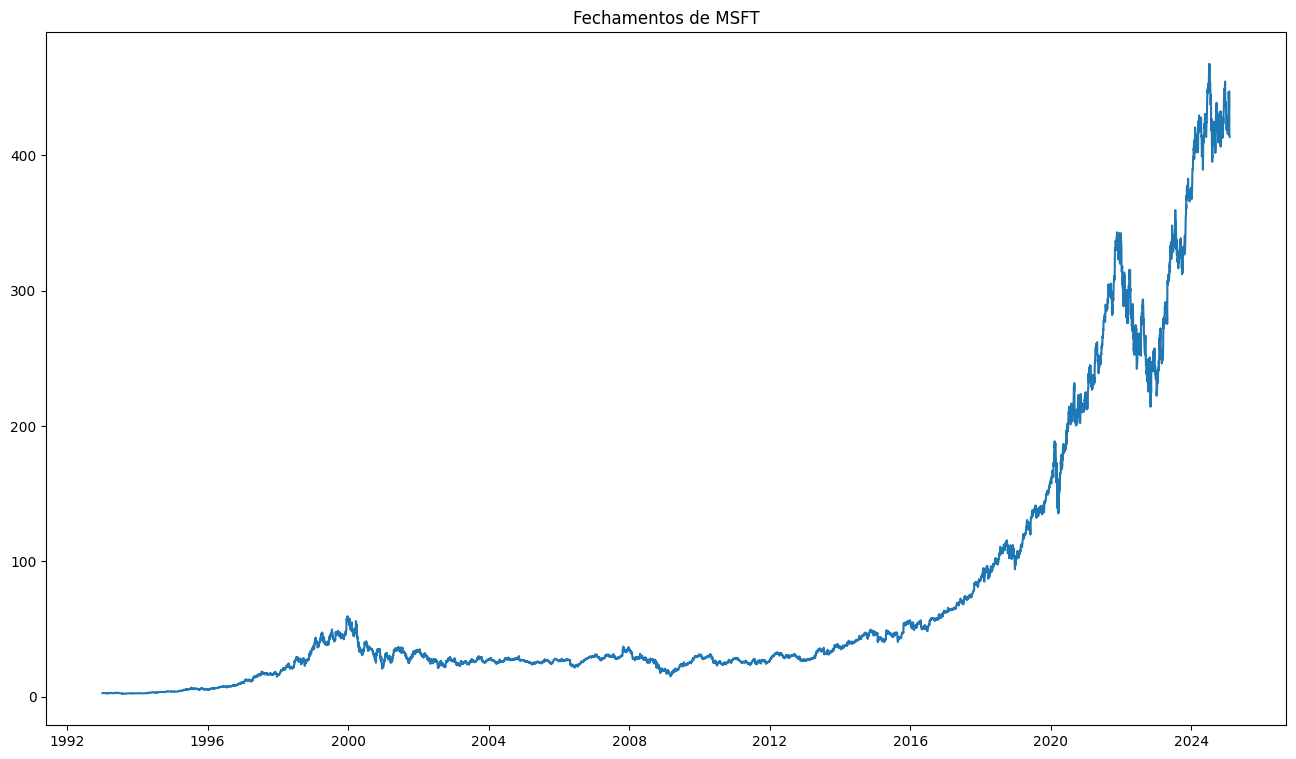

In [ ]:
#Vamos plotar num grafico o comportamento da ação ao longo do tempo
plt.figure(figsize =(16,9))
plt.title('Fechamentos de MSFT')
plt.plot(fechamento)
plt.show()


Agora vamos fazer uma ánalise exploratória

In [ ]:
#Vamos plotar um grafico de barras da variação e relação ao volume
fig = px.bar(dados, x='Data', y=['Var%','Vol.'])
fig.show()

Agora vamos buscar alguns indicadores como quais meses o volume é maior, qual mes o volume de negociação é maior para posteriormente tentarmos achar alguma correlação

In [ ]:
#vamos avaliar quais Mêses tem maior volume de negociação
dados['Mês'] = dados['Data'].dt.month
volume_por_mes = dados['Vol.'] * 1000000
volume_por_mes = dados.groupby('Mês')['Vol.'].sum()


fig = px.bar(volume_por_mes, x=volume_por_mes.index, y=volume_por_mes.values)
fig.update_layout(
    title='Volume de Negociação por Mês',
    xaxis_title='Mês',
    yaxis_title='Volume de Negociação (em milhões)'
)
fig.show()

Pudemos Ver que os meses com maior volume de negociação é Janeiro e Outubro, e os meses com menor volume de negociação é Agosto, Setembro, Dezembro.
O que pode evidenciar uma Sazonalidade, e coincidir com Férias e/ou Eventos da microsoft e divulgação de resultados financeiros.

Separando por trimestes

1º o Primeiro trimeste demonsta um maior volume de transações mostrando-se acima dos outros podendo ser mais volatil em questão de preços *investigaremos mais a frente*

2º o segundo trimestre ainda é forte porem com menor força em relação ao primeiro com volume ainda consideravel porem com um final mais fraco mostrando um volume bem abaixo que pode evindenciar uma estabilidade nos preços *investigaremos mais a frente*

3º começa com muito volume mas rapidamente cais nos meses seguintes podendo ser por causa do inicio do verão e as ferias.

4º começa com volume bem acima porem cai nos meses seguintes ainda sendo afetado possivelmente pelas férias de verão e tambem devido ao baixo volume de operação do meses que passaram podem puxar o preço para valores com pouca variação desincentivando as operações.

vamos analisar agora a variação por mês

In [ ]:
dados['Mês'] = dados['Data'].dt.month
variacao_por_mes = dados['Var%']
variacao_por_mes = dados.groupby('Mês')['Var%'].sum()

fig = px.bar(variacao_por_mes, x=variacao_por_mes.index, y=variacao_por_mes.values)
fig.update_layout(
    title='Variacao por Mês',
    xaxis_title='Mês',
    yaxis_title='variacao em porcentagem'
)
fig.show()

como pudemos ver os meses de fevereiro e setembro tem valores de variação negativa o que pode evidenciar mais ainda a sazonalidade e/ou coincidir com publicação dos resultados financeiros no caso a espera da publicação e logo após vemos o volume aumentar novamente.

vamos nos aprofundar na nossa analise e levantar algumas hipoteses.

Vamos fazer um grafico de correlação entre preço de fechamento, volume e variação para tentar levantar hipoteses, poderiamos ter criado uma função para plotar o grafico com as colunas selecionadas mas assim como nas anteriores vamos fazer uma a uma com intuito de estudo de fixação do metodo de  plot do grafico.

In [ ]:
#Correlação entre fechamento volume e variação
corr_ult_var_vol = dados[['Último','Vol.','Var%']]
corr_ult_var_vol.corr()

,Último,Vol.,Var%
Último,1.000000,-0.410147,0.006352
Vol.,-0.410147,1.000000,-0.011040
Var%,0.006352,-0.011040,1.000000


<Axes: >

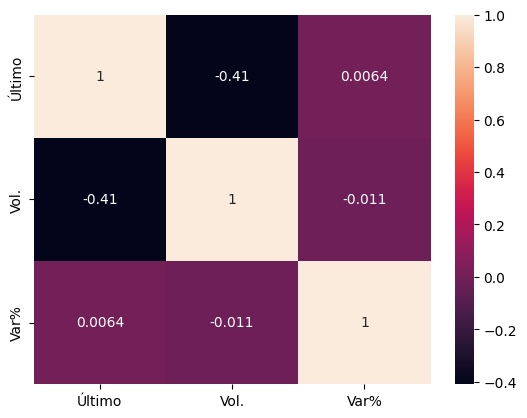

In [ ]:
#Heatmap da correlação entre ultimo volume e variação
sns.heatmap(corr_ult_var_vol.corr(), annot=True)

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8079 entries, 0 to 8079
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      8079 non-null   datetime64[ns]
 1   Último    8079 non-null   float64       
 2   Abertura  8079 non-null   float64       
 3   Máxima    8079 non-null   float64       
 4   Mínima    8079 non-null   float64       
 5   Vol.      8079 non-null   float64       
 6   Var%      8079 non-null   float64       
 7   Mês       8079 non-null   int32         
dtypes: datetime64[ns](1), float64(6), int32(1)
memory usage: 536.5 KB


In [ ]:
#Correlaçao entre abertura, volume e variação
corr_aber_var_vol = dados[['Abertura','Vol.','Var%']]
corr_aber_var_vol.corr()

,Abertura,Vol.,Var%
Abertura,1.000000,-0.409938,-0.001279
Vol.,-0.409938,1.000000,-0.011040
Var%,-0.001279,-0.011040,1.000000


<Axes: >

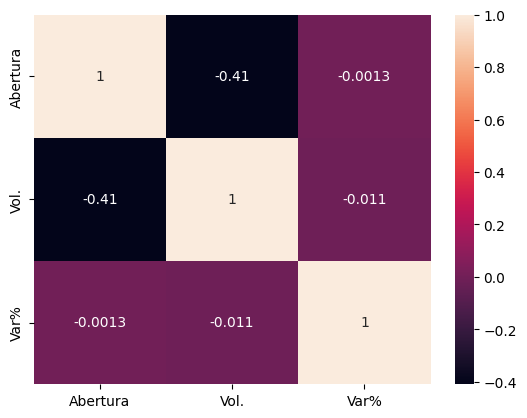

In [ ]:
#Heatmap da correlação entre abertura, volume e variação
sns.heatmap(corr_aber_var_vol.corr(), annot=True)

In [ ]:
#Correlaçao entre minima, volume e variação
corr_min_var_vol = dados[['Mínima','Vol.','Var%']]
corr_min_var_vol.corr()

,Mínima,Vol.,Var%
Mínima,1.000000,-0.411302,0.00246
Vol.,-0.411302,1.000000,-0.01104
Var%,0.002460,-0.011040,1.00000


<Axes: >

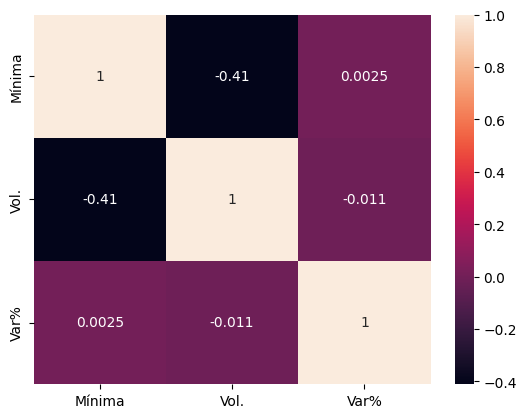

In [ ]:
#Heatmap da correlação entre minima, volume e variação
sns.heatmap(corr_min_var_vol.corr(), annot=True)

In [ ]:
#Correlaçao entre minima, volume e variação
corr_mes_var_vol = dados[['Mês','Vol.','Var%']]
corr_mes_var_vol.corr()

,Mês,Vol.,Var%
Mês,1.000000,-0.053363,-0.002094
Vol.,-0.053363,1.000000,-0.011040
Var%,-0.002094,-0.011040,1.000000


<Axes: >

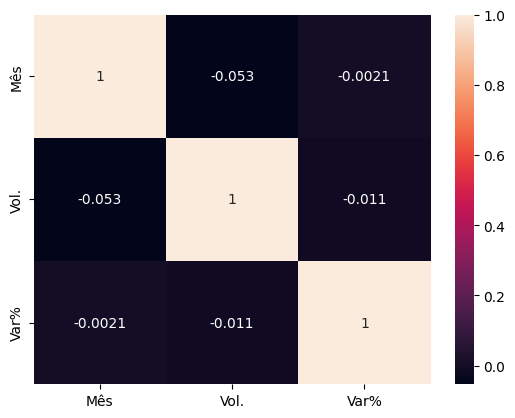

In [ ]:
#Heatmap da correlação entre minima, volume e variação
sns.heatmap(corr_mes_var_vol.corr(), annot=True)

Conclusão das correlações:

Correlação inversa moderada:
O valor de Abertura tem correlação inversa moderada ao volume, então se o volume aumentar a tendencia e da abertura ser menor e vice/versa

O valor de minima tem correlação inversa moderada ao volume, então se o volume aumentar a tendencia é da minima cair e vice/versa

O valor de fechamento tem correlação inversa moderada ao volume, então se o volume aumentar a tendencia é do fechamento ser menor e vice/versa

não existe correlação relevante entre volume variação e os meses do ano nem com as outras variaveis



Agora vamos começar a seprarar os dados para modelagem e insersão no modelo de aprendizado de maquina

In [ ]:
X = dados[['Abertura', 'Máxima', 'Mínima', 'Vol.']]
y = dados['Último']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Criando e treinando o modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliando o modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 2.415407697736505
Mean Absolute Error (MAE): 0.698704534556606
R-squared (R2): 0.9997819505525644


In [33]:
tomorrow_features = pd.DataFrame({
    'Abertura': [412.35],
    'Máxima': [413.83],
    'Mínima': [410.40],
    'Vol.': [1630]
})

tomorrow_prediction = model.predict(tomorrow_features)
print(f"Predicted closing price for tomorrow: {tomorrow_prediction[0]}")

Predicted closing price for tomorrow: 415.48065185546875


#Relatório de observação das previsões
Decidi acompanhar dia a dia, vou fazer previsões para o proximo dia com valores de "  **'Abertura'** , **'Máxima'** ,' **Mínima'** e
 **'Vol.'**  para prever o valor de fechamento do dia seguinte, vou documentar no final dos dias durante 10 dias e vou avaliar manualmente a acuracia do modelo.

Dia 04/02/2025:  
Predito: 412,50
Real: 412,21

Dia 05/02/2025:  
Predito:413.51
Real:413,29


Dia 06/02/2025:  
Predito: 415.48
Real:

Dia 07/02/2025:  
Predito:  
Real:

Dia 08/02/2025:  
Predito:  
Real:

Dia 09/02/2025:  
Predito:  
Real:

Dia 10/02/2025:  
predito:  
real:

Dia 11/02/2025:  
predito:  
real:

Dia 12/02/2025:  
predito:  
real:

Dia 13/02/2025:  
predito:  
real:

Dia 14/02/2025:  
predito:  
real: